# Prepare the Environment


In [ ]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# Import a bunch of libraries.
from collections import Counter, OrderedDict
import statistics
import operator

import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns
import scipy.stats as ss

import xgboost
import pickle

from scipy.stats import norm
from sklearn.linear_model import LinearRegression

from sklearn.model_selection import GridSearchCV
from pandas import read_csv

from sklearn.ensemble import IsolationForest
import sklearn.metrics

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Lasso

# flag for verbose printout of lengthy functions
verbose = False

# flag for submission file creation
submission = False

In [ ]:
pd.set_option('max_columns', None)

## Function to create submission file

In [ ]:
def submission_file(y_pred, filename):

  pred=pd.DataFrame(y_pred)
  sub_df=pd.read_csv('https://raw.githubusercontent.com/rambles-tech/w207_final_project_kaggle/main/data/sample_submission.csv')

  # grab just the ID from sample_submission.csv
  datasets=pd.concat([sub_df['Id'],pred],axis=1)
  
  # append y_pred to newly-created DF
  datasets.columns=['Id','SalePrice']
  
  # write to file
  datasets.to_csv(filename,index=False)

# Bring in the Data

In [ ]:
train_data = pd.read_csv("https://raw.githubusercontent.com/rambles-tech/w207_final_project_kaggle/main/data/train.csv")
test_data = pd.read_csv("https://raw.githubusercontent.com/rambles-tech/w207_final_project_kaggle/main/data/test.csv")

# combine train and test data for ease of feature engineering
data = pd.concat([train_data, test_data]) #1459 is last training_data entry


# EDA

Confirm the shape of the data  
*Note: test_data should have one less column (sale_price)*

In [ ]:
print(train_data.shape)
print(test_data.shape)
print(data.shape)

(1460, 81)
(1459, 80)
(2919, 81)


## Validate Data

The following dictionary is created from the original data description and inference following domain-specific research.  This will be used to check for inconsistent or incorrect values in the dataset.

In [ ]:
# feature values
feature_values_dict = {
    ### NUMERIC FEATURES ###
    'LotFrontage': [0,1000000], 
    'LotArea' : [0,1000000], 
    'MasVnrArea' : [0, 10000], 
    'BsmtFinSF1' : [0, 10000], 
    'BsmtFinSF2' :[0, 10000], 
    'BsmtUnfSF' : [0, 10000], 
    'TotalBsmtSF' : [0, 10000], 
    '1stFlrSF' : [0, 10000], 
    '2ndFlrSF' : [0, 10000], 
    'LowQualFinSF' : [0, 10000], 
    'GrLivArea': [0, 10000], 
    'BsmtFullBath' : [0, 10],
    'BsmtHalfBath' : [0, 10],
    'FullBath' : [0, 10], 
    'HalfBath' : [0, 10], 
    'BedroomAbvGr' : [0, 10], 
    'KitchenAbvGr' : [0, 10], 
    'TotRmsAbvGrd' : [0, 20], 
    'Fireplaces' : [0, 5], 
    'GarageCars' : [0,10000], 
    'GarageArea': [0, 10000], 
    'WoodDeckSF' : [0, 2000], 
    'OpenPorchSF' : [0, 2000], 
    'EnclosedPorch' : [0, 2000], 
    '3SsnPorch' : [0, 2000], 
    'ScreenPorch' : [0, 2000], 
    'PoolArea' : [0, 2000], 
    'MiscVal' : [0, 50000], 
    'SalePrice' : [0,1000000],

    ### CATEGORICAL and ORDINAL FEATURES ###
    'Id' : [1,2919],
    'MSSubClass': [20,30,40,45,50,60,70,75,80,85,90,120,150,160,180,190],
    'MSZoning': ['A','C','FV', 'I', 'RH','RL', 'RP', 'RM'], 
    'Street' : ['Grvl', 'Pave'], 
    'Alley' : ['Grvl', 'Pave', 'NA'], 
    'LotShape' : ['Reg', 'IR1', 'IR2','IR3'], 
    'LandContour' : ['Lvl', 'Bnk', 'HLS', 'Low'], 
    'Utilities' : ['AllPub', 'NoSewr', 'NoSeWa', 'ELO'], 
    'LotConfig' : ['Inside', 'Corner', 'CulDSac', 'FR2', 'FR3'], 
    'LandSlope': ['Gtl', 'Mod', 'Sev'], 
    'Neighborhood' : ['Blmngtn', 'Blueste', 'BrDale', 'BrkSide', 'ClearCr', 
                      'CollgCr', 'Crawfor', 'Edwards', 'Gilbert', 'IDOTRR',
                      'MeadowV', 'Mitchel', 'Names', 'NoRidge', 'NPkVill', 
                      'NridgHt', 'NWAmes', 'OldTown', 'SWISU', 'Sawyer', 
                      'SawyerW', 'Somerst', 'StoneBr', 'Timber', 'Veenker'], 
    'Condition1' : ['Artery', 'Feedr', 'Norm', 'RRNn', 'RRAn', 'PosN', 'PosA', 'RRNe', 'RRAe'], 
    'Condition2' : ['Artery', 'Feedr', 'Norm', 'RRNn', 'RRAn', 'PosN', 'PosA', 'RRNe', 'RRAe'], 
    'BldgType' : ['1Fam', '2FmCon', 'Duplx', 'TwnhsE', 'TwnhsI'],
    'HouseStyle' : ['1Story', '1.5Fin', '1.5Unf', '2Story', '2.5Fin', '2.5Unf', 'SFoyer', 'SLvl'], 
    'OverallQual' : [1,2,3,4,5,6,7,8,9,10], 
    'OverallCond' : [1,2,3,4,5,6,7,8,9,10], 
    'YearBuilt' : [1850,2010], 
    'YearRemodAdd' : [1850,2010], 
    'RoofStyle' : ['Flat', 'Gable', 'Gambrel', 'Hip', 'Mansard', 'Shed'], 
    'RoofMatl' : ['ClyTile', 'CompShg', 'Membran', 'Metal', 'Roll', 'Tar&Grv', 'WdShake', 'WdShngl'], 
    'Exterior1st' : ['AsbShng', 'AsphShn', 'BrkComm', 'BrkFace', 'CBlock' , 'CemntBd', 'HdBoard', 'ImStucc', 'MetalSd', 'Other', 'Plywood', 'PreCast', 'Stone', 'Stucco', 'VinylSd', 'Wd Sdng', 'WdShing'], 
    'Exterior2nd' : ['AsbShng', 'AsphShn', 'BrkComm', 'BrkFace', 'CBlock' , 'CemntBd', 'HdBoard', 'ImStucc', 'MetalSd', 'Other', 'Plywood', 'PreCast', 'Stone', 'Stucco', 'VinylSd', 'Wd Sdng', 'WdShing'],
    'MasVnrType' : ['BrkCmn','BrkFace','CBlock','None','Stone'], 
    'ExterQual' : ['Ex', 'Gd', 'TA', 'Fa', 'Po'], 
    'ExterCond' : ['Ex', 'Gd', 'TA', 'Fa', 'Po'], 
    'Foundation' : ['BrkTil', 'CBlock', 'PConc', 'Slab', 'Stone', 'Wood'], 
    'BsmtQual' : ['Ex', 'Gd', 'TA', 'Fa', 'Po', 'NA'], 
    'BsmtCond' : ['Ex', 'Gd', 'TA', 'Fa', 'Po', 'NA'], 
    'BsmtExposure': ['Gd', 'Av', 'Mn', 'No', 'NA'], 
    'BsmtFinType1' : ['GLQ', 'ALQ', 'BLQ', 'Rec', 'LwQ', 'Unf', 'NA'],
    'BsmtFinType2' : ['GLQ', 'ALQ', 'BLQ', 'Rec', 'LwQ', 'Unf', 'NA'], 
    'Heating' : ['Floor', 'GasA', 'GasW', 'Grav', 'OthW', 'Wall'], 
    'HeatingQC' : ['Ex', 'Gd', 'TA', 'Fa', 'Po'], 
    'CentralAir' : ['N', 'Y'], 
    'Electrical' : ['SBrkr', 'FuseA', 'FuseF', 'FuseP', 'Mix'], 
    'KitchenQual': ['Ex', 'Gd', 'TA', 'Fa', 'Po'], 
    'Functional': ['Typ', 'Min1', 'Min2', 'Mod', 'Maj1', 'Maj2', 'Sev', 'Sal'], 
    'FireplaceQu': ['Ex', 'Gd', 'TA', 'Fa', 'Po', 'NA'], 
    'GarageType' : ['2Types', 'Attchd', 'Basment', 'BuiltIn', 'CarPort', 'Detchd', 'NA'], 
    'GarageYrBlt':[1850, 2010], 
    'GarageFinish' : ['Fin', 'RFn', 'Unf', 'NA'], 
    'GarageQual' : ['Ex', 'Gd', 'TA', 'Fa', 'Po', 'NA'], 
    'GarageCond' : ['Ex', 'Gd', 'TA', 'Fa', 'Po', 'NA'], 
    'PavedDrive' : ['Y', 'P', 'N'], 
    'PoolQC' : ['Ex', 'Gd', 'TA', 'Fa', 'NA'], 
    'Fence': ['GdPrv', 'MnPrv', 'GdWo', 'MnWw', 'NA'], 
    'MiscFeature': ['Elev', 'Gar2', 'Othr', 'Shed', 'TenC', 'NA'], 
    'MoSold' : [1,2,3,4,5,6,7,8,9,10,11,12], 
    'YrSold' : [2006, 2007, 2008, 2009, 2010], 
    'SaleType' : ['WD', 'CWD', 'VWD', 'New', 'COD', 'Con', 'ConLw', 'ConLI', 'ConLD', 'Oth'],
    'SaleCondition' : ['Normal', 'Abnorml', 'AdjLand', 'Alloca', 'Family', 'Partial']
}

This function will compare vaues of each feature in the dataset against the above-created dictionary of valid ranges/values.

In [ ]:
# examine the feature stats
def examine_feature(df,list_features,dict_values):
  for feature in list_features:
    print(df[feature].head())

    # create a dictionary of keys and values
    class_keys = Counter(df[feature]).keys()
    class_values = Counter(df[feature]).values()
    
    class_dict = dict(zip(class_keys,class_values))

    # sort dict by values
    od_values = dict(sorted(class_dict.items(), key=lambda item: item[1]))

    # variable to hold the count
    cnt = 0
    
    # list to hold visited values
    visited = []

    # loop for counting the unique values in feature
    for i in range(0, len(df[feature])):
      if df[feature].iloc[i] not in visited: 
        visited.append(df[feature].iloc[i])
        cnt += 1

    # sort the list of unique visited feature values
    visited.sort(key=repr)
    if isinstance(data[feature].iloc[0],np.int64) or isinstance(data[feature].iloc[0],np.float64):
      print('min =',df[feature].min())
      print('max =',df[feature].max())
      visited.sort()

    print('value sort     :',od_values)
    print('# of samples   :',len(df))
    print('nans =',len(df[df[feature].isna()]))
    print('# of uniques   :',cnt)
    print('unique values  :',visited)

    print('possible values:',sorted(dict_values[feature]))
    print('cat not in list:',(list(set(visited)-set(dict_values[feature]))))
    print('cat to add as col:',(list(set(dict_values[feature])-set(visited))))
    print('*************')

In [ ]:
# examine feature values 
if verbose: examine_feature(data,data.columns,feature_values_dict)
else: print("Output suppressed; set `verbose` to True if output is desired")


Output suppressed; set `verbose` to True if output is desired


## Identify Duplicate Entries

In [ ]:
# no duplicate id's
data.Id.unique().size

2919

No duplicate data found

## Identify Missing Data  

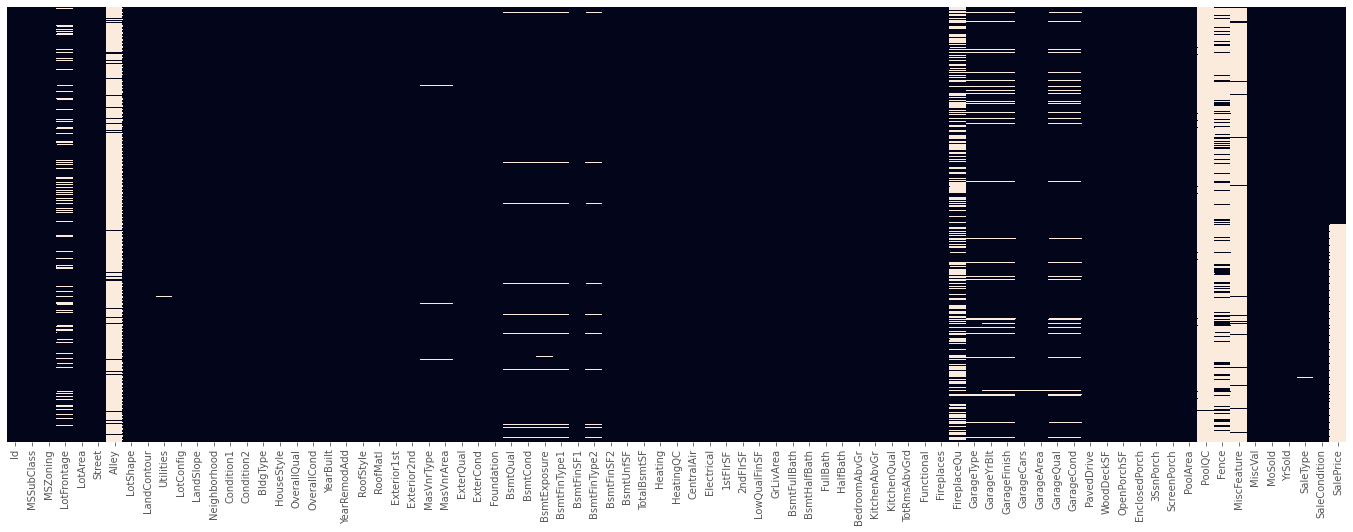

In [ ]:
plt.figure(figsize=(24,8))
sns.heatmap(data.isnull(),yticklabels=False,cbar=False)
plt.show()

In [ ]:
# find NA values, sorted by columns with most NA entries
data.isnull().sum(0).sort_values(ascending=False).head(36)

PoolQC          2909
MiscFeature     2814
Alley           2721
Fence           2348
SalePrice       1459
FireplaceQu     1420
LotFrontage      486
GarageQual       159
GarageYrBlt      159
GarageFinish     159
GarageCond       159
GarageType       157
BsmtExposure      82
BsmtCond          82
BsmtQual          81
BsmtFinType2      80
BsmtFinType1      79
MasVnrType        24
MasVnrArea        23
MSZoning           4
Utilities          2
Functional         2
BsmtFullBath       2
BsmtHalfBath       2
GarageArea         1
BsmtFinSF2         1
Exterior1st        1
TotalBsmtSF        1
GarageCars         1
BsmtUnfSF          1
Electrical         1
BsmtFinSF1         1
KitchenQual        1
SaleType           1
Exterior2nd        1
Street             0
dtype: int64

## Identify Incorrect Data

### The Neighborhood Level

Lets compare values at the data-set level compared with the neighborhood level

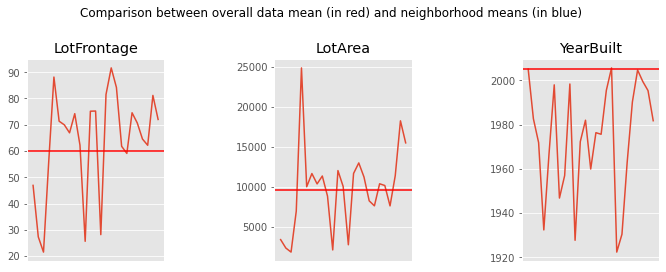

In [ ]:
examples = ['LotFrontage', 'LotArea', 'YearBuilt']

fig, axes = plt.subplots(1, len(examples))

#plt.figure(figsize=(20,10)) 
fig.suptitle('Comparison between overall data mean (in red) and neighborhood means (in blue)')
fig.tight_layout()

for i, feature in enumerate(data[examples].columns):
  
  if data[feature].dtypes == 'int64' or data[feature].dtypes == 'float64' :
    axes[i].set_title(feature)
    # plot the mean by neighborhood
    axes[i].plot( data.groupby('Neighborhood')[feature].mean()  )

    # plot the overall mean
    axes[i].axhline(y = data[feature].value_counts().idxmax(), color = 'r', linestyle = '-') 

    axes[i].get_xaxis().set_visible(False)
  else:
    
    print(feature)
    print("Overall Mode")
    print(data[feature].value_counts().idxmax())

    print("Neighborhood Modes")
    print(data.groupby('Neighborhood')[feature].value_counts().idxmax())

plt.subplots_adjust(left=None, bottom=None, right=None, top=.8, wspace=.8, hspace=None)
plt.gcf().set_size_inches(10, 4)
plt.show()

**Recommendation: Considering the extreme changes by neighborhood, we recommend using means and modes at the neighborhood level when considering imputing missing values.**

In [ ]:
data[(data.Neighborhood == 'Blmngtn') & (data.LotArea == 3182)]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
229,230,120,RL,43.0,3182,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Blmngtn,Norm,Norm,TwnhsE,1Story,7,5,2005,2006,Gable,CompShg,VinylSd,VinylSd,BrkFace,16.0,Gd,TA,PConc,Gd,TA,Av,GLQ,16.0,Unf,0.0,1357.0,1373.0,GasA,Ex,Y,SBrkr,1555,0,0,1555,0.0,0.0,2,0,2,1,Gd,7,Typ,1,TA,Attchd,2005.0,Fin,2.0,430.0,TA,TA,Y,143,20,0,0,0,0,NaN,NaN,NaN,0,5,2009,WD,Normal,192500.0
385,386,120,RL,43.0,3182,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Blmngtn,Norm,Norm,TwnhsE,1Story,8,5,2004,2005,Gable,CompShg,VinylSd,VinylSd,BrkFace,16.0,Gd,TA,PConc,Gd,TA,No,GLQ,24.0,Unf,0.0,1232.0,1256.0,GasA,Ex,Y,SBrkr,1269,0,0,1269,0.0,0.0,2,0,2,1,Gd,6,Typ,1,TA,Attchd,2004.0,Fin,2.0,430.0,TA,TA,Y,146,20,0,0,144,0,NaN,NaN,NaN,0,4,2010,WD,Normal,192000.0
790,791,120,RL,43.0,3182,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Blmngtn,Norm,Norm,TwnhsE,1Story,7,5,2005,2006,Gable,CompShg,VinylSd,VinylSd,BrkFace,11.0,Gd,TA,PConc,Gd,TA,No,GLQ,16.0,Unf,0.0,1129.0,1145.0,GasA,Ex,Y,SBrkr,1145,0,0,1145,0.0,0.0,2,0,2,1,Gd,5,Typ,1,Gd,Attchd,2005.0,Fin,2.0,397.0,TA,TA,Y,100,16,0,0,0,0,NaN,NaN,NaN,0,9,2009,WD,Normal,160200.0
982,983,20,RL,43.0,3182,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Blmngtn,Norm,Norm,1Fam,1Story,7,5,2007,2007,Gable,CompShg,VinylSd,VinylSd,BrkFace,16.0,Gd,TA,PConc,Gd,TA,Av,Unf,0.0,Unf,0.0,1266.0,1266.0,GasA,Ex,Y,SBrkr,1266,0,0,1266,0.0,0.0,2,0,2,1,Gd,6,Typ,1,Gd,Attchd,2007.0,Fin,2.0,388.0,TA,TA,Y,100,16,0,0,0,0,NaN,NaN,NaN,0,3,2008,WD,Normal,159895.0
1004,1005,120,RL,43.0,3182,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Blmngtn,Norm,Norm,TwnhsE,1Story,7,5,2005,2006,Gable,CompShg,VinylSd,VinylSd,BrkFace,16.0,Gd,TA,PConc,Gd,TA,No,GLQ,16.0,Unf,0.0,1330.0,1346.0,GasA,Ex,Y,SBrkr,1504,0,0,1504,0.0,0.0,2,0,1,1,Gd,7,Typ,1,Gd,Attchd,2005.0,Fin,2.0,457.0,TA,TA,Y,156,0,0,0,0,0,NaN,NaN,NaN,0,5,2009,WD,Normal,181000.0
1023,1024,120,RL,43.0,3182,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Blmngtn,Norm,Norm,TwnhsE,1Story,7,5,2005,2006,Gable,CompShg,VinylSd,VinylSd,BrkFace,14.0,Gd,TA,PConc,Gd,Gd,No,GLQ,16.0,Unf,0.0,1330.0,1346.0,GasA,Ex,Y,SBrkr,1504,0,0,1504,0.0,0.0,2,0,2,1,Gd,7,Typ,1,Gd,Attchd,2005.0,Fin,2.0,437.0,TA,TA,Y,156,20,0,0,0,0,NaN,NaN,NaN,0,5,2008,WD,Normal,191000.0
225,1686,120,RL,43.0,3182,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Blmngtn,Norm,Norm,TwnhsE,1Story,7,5,2005,2006,Gable,CompShg,VinylSd,VinylSd,BrkFace,16.0,Gd,TA,PConc,Gd,TA,Av,GLQ,16.0,Unf,0.0,1204.0,1220.0,GasA,Ex,Y,SBrkr,1220,0,0,1220,0.0,0.0,2,0,2,1,Gd,5,Typ,1,Gd,Attchd,2005.0,Fin,2.0,397.0,TA,TA,Y,100,16,0,0,0,0,NaN,NaN,NaN,0,8,2009,WD,Normal,NaN


In [ ]:
# Check for standardized values at the neighborhood level
data[['Id','Neighborhood','MSSubClass','MSZoning']][data['Neighborhood'] == 'BrkSide']

,Id,Neighborhood,MSSubClass,MSZoning
9,10,BrkSide,190,RL
15,16,BrkSide,45,RM
29,30,BrkSide,30,RM
51,52,BrkSide,50,RM
77,78,BrkSide,50,RM
...,...,...,...,...
1005,2466,BrkSide,50,RL
1332,2793,BrkSide,70,RL
1333,2794,BrkSide,50,RM
1334,2795,BrkSide,50,RM


There could potentially be some misclassified `MSSubClass` & `MSZoning` values.  Is it possible the same Neighborhood be both Residencial Medium (RM) and Low (RL) Density?  
**Recommendation: Conduct research to determine if houses within the same neighborhood could potentially have differing values.**



### The House Level

In [ ]:
data[(data.YearBuilt > 2010) | (data.YearRemodAdd > 2010)]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice


There are no houses built or remodeled after 2010.

In [ ]:
# Check for illogical sequences
data[['Id','YearBuilt','YearRemodAdd','Neighborhood']][data['YearBuilt'] > data['YearRemodAdd']]

,Id,YearBuilt,YearRemodAdd,Neighborhood
416,1877,2002,2001,CollgCr


Here, we found one case where `YearRemodAdd` was likely incorrectly entered prior to the `YearBuilt`.

**Recommendation: Drop or change this value for YearRemodAdd to 2002
or add a flat indictor variable for Remodeled**

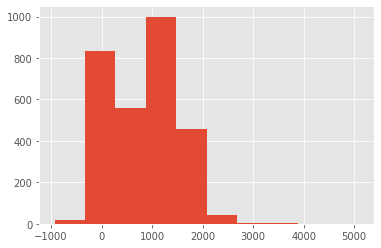

,Id,1stFlrSF,2ndFlrSF
157,158,774,1194
362,363,495,1427
800,801,616,1072
1360,1361,990,1611
133,1594,862,1788
301,1762,825,1315
401,1862,1168,1619
402,1863,1168,1619
403,1864,1168,1619
695,2156,1093,1721


In [ ]:
# no errors: houses with more than 400 square feet on 2nd floor than the 1st
temp_list = data['1stFlrSF'] - data['2ndFlrSF']
plt.hist(temp_list,bins=10)
plt.show()

df_temp = data[['Id','1stFlrSF','2ndFlrSF']]
df_temp[((df_temp['1stFlrSF'] - df_temp['2ndFlrSF']) < -400)].head(20)


It is unclear if this is an error or a factor of architectural design.    
**Recommend not changing anything, but certainly be aware of this issue if predictions are not in compliance.**

In [ ]:
# Check for potential misclassifications
df_temp = (data[(data.HouseStyle == '1Story') & 
                        (data['2ndFlrSF'] > 0)])
df_temp[['Id','MSSubClass','HouseStyle','1stFlrSF','2ndFlrSF']]


,Id,MSSubClass,HouseStyle,1stFlrSF,2ndFlrSF
164,165,40,1Story,1149,467
1270,1271,40,1Story,1332,192
994,2455,40,1Story,916,144


There are three houses which are misclassified as 1 story houses yet they have a 2nd floor.  
**Recommendation: Keep.  This could potentially cover a finished attic.  Since they are so few entries with this error, it would be unneccessary to drop these rows.**

### The Basement

In [ ]:
# counts match
print(data[(data.BsmtFinSF1 > 0)].shape[0])
print(data[(data.BsmtFinSF2 > 0)].shape[0])
#print(data[(data.BsmtFinSF1.isnull())])
data[['Id','BsmtFinSF1']].iloc[2120]

1989
347


Id            2121.0
BsmtFinSF1       NaN
Name: 660, dtype: float64

There does not seeom to be any discrepancies between the counts of BsmtFinSF1 and BsmtFinSF2.

There is at least one NaN value in this feature that must be addressed.

**Recommendation: Replace BsmtFinSF1 NaN with neighborhood mean.**



### The Garage

In [ ]:
# check for valid garage entries
data[['Id','YearBuilt','YearRemodAdd','GarageYrBlt']][(data.GarageYrBlt > 2010)]

,Id,YearBuilt,YearRemodAdd,GarageYrBlt
1132,2593,2006,2007,2207.0


There is one value that is clearly an entry error.  
**Recommendation: Either drop this entry, change to YearBuilt to match the house, change to 2007, or replace with neighborhood mean.**


In [ ]:
# find garages built before the houses
data[['Id','YearBuilt','GarageYrBlt']][(data.GarageYrBlt < data.YearBuilt)]

,Id,YearBuilt,GarageYrBlt
29,30,1927,1920.0
93,94,1910,1900.0
324,325,1967,1961.0
600,601,2005,2003.0
736,737,1950,1949.0
1103,1104,1959,1954.0
1376,1377,1930,1925.0
1414,1415,1923,1922.0
1418,1419,1963,1962.0
61,1522,1959,1956.0


**Recommendation: Keep these values.  Without additional research and more data, it is likely not possible to rule these as errors and not a result of a house being demolished while the garage remains.**

### The Lot

In [ ]:
# Check various features of the lots
depth = (data.LotArea / data.LotFrontage)
df_temp = pd.DataFrame(data.Id)
df_temp['LotFrontage'] = data.LotFrontage
df_temp['depth'] = depth
df_temp['LotArea'] = data.LotArea
print(df_temp.max())
print(df_temp.min())
print(df_temp[(df_temp.depth < 75)].head())

Id               2919.000000
LotFrontage       313.000000
depth            1434.966667
LotArea        215245.000000
dtype: float64
Id                1.000000
LotFrontage      21.000000
depth            26.915033
LotArea        1300.000000
dtype: float64
      Id  LotFrontage      depth  LotArea
198  199         92.0  60.000000     5520
204  205         50.0  70.000000     3500
219  220         43.0  70.000000     3010
229  230         43.0  74.000000     3182
276  277        129.0  71.286822     9196


Nothing significant to report.

In [ ]:
# check for lot plus building total
data[['Id','LotArea',
         '1stFlrSF','GarageArea','WoodDeckSF',
         'OpenPorchSF','EnclosedPorch','ScreenPorch',
         'PoolArea']][(data['1stFlrSF'] + data.GarageArea + data.WoodDeckSF + data.OpenPorchSF + data.EnclosedPorch + data.ScreenPorch + data.PoolArea)
          > data.LotArea]

,Id,LotArea,1stFlrSF,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,ScreenPorch,PoolArea
1358,2819,1700,880,450.0,188,36,0,200,0


There is one entry where the total areas of each component sum greater than the total lot - more square footage of buildings(plus) than the lot.  
**Recommendation: Although this entry should be dropped, since it a test subject, the value should be adjusted to equal the sum of components.**

In [ ]:
# Check for LotFrontAge Issues
data[['Id','LotFrontage','LotArea']][(data.LotFrontage < 24)].sort_values(by=['LotArea'], ascending=False).head()

,Id,LotFrontage,LotArea
578,2039,22.0,11064
1007,1008,21.0,2217
822,2283,21.0,2205
823,2284,21.0,2058
915,916,21.0,2001


Id 2039 LotFrontage and LotArea seem complex and likely is the result of an error.  
**Recommendation: This appears to be an extreme outlier, but it is in the test data.  Potentially, this value could be weighted to be more inline with the rest of the samples, but that would not achieve much of an effect.**


## Sales Price

In [ ]:
# examine the sales price data
round(train_data.SalePrice.describe(), 2)

count      1460.0
mean     180921.2
std       79442.5
min       34900.0
25%      129975.0
50%      163000.0
75%      214000.0
max      755000.0
Name: SalePrice, dtype: float64

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


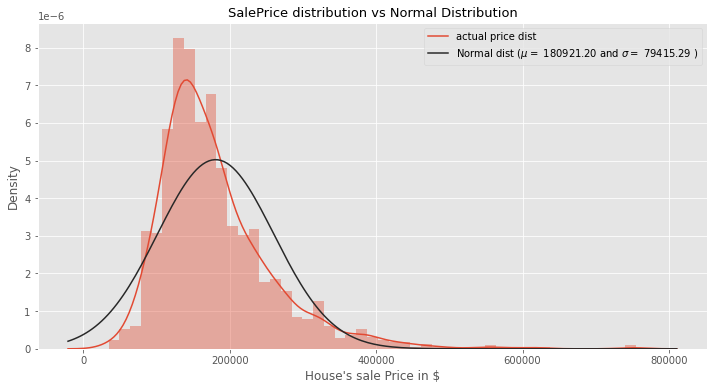

In [ ]:
(mu, sigma) = norm.fit(train_data['SalePrice'])
plt.figure(figsize = (12,6))
sns.distplot(train_data['SalePrice'], kde = True, hist=True, fit = norm)
plt.title('SalePrice distribution vs Normal Distribution', fontsize = 13)
plt.xlabel("House's sale Price in $", fontsize = 12)
plt.legend(['actual price dist','Normal dist ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],loc='best')
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


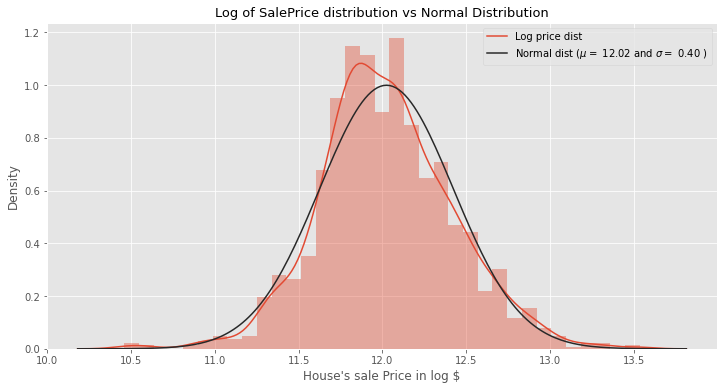

In [ ]:
(mu, sigma) = norm.fit(np.log(train_data['SalePrice']))
plt.figure(figsize = (12,6))
sns.distplot(np.log(train_data['SalePrice']), kde = True, hist=True, fit = norm)
plt.title('Log of SalePrice distribution vs Normal Distribution', fontsize = 13)
plt.xlabel("House's sale Price in log $", fontsize = 12)
plt.legend(['Log price dist','Normal dist ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],loc='best')
plt.show()

**Recommendation: Use Log-Transform on SalesPrice for Linear Models since it increases the accuracy of the normality assumption.**


## Consolidated Recommendations

- Recommendation: Considering the extreme changes by neighborhood, we recommend using means and modes at the neighborhood level when considering imputing missing values.  **done**  
- Recommendation: Drop or change id==1877 value for YearRemodAdd to 2002 or add a flat indictor variable for Remodeled **done**  
- Recommendation: Either drop id==2593 entry, change to YearBuilt to match the house, change to 2007, or replace with neighborhood mean.  **unneeded, its test data**  
- Recommendation: Drop 2819 **unneeded, its test data**  
    - There is one entry where the total areas of each component sum greater than the total lot - more square footage of buildings(plus) than the lot.
- Id 2039 LotFrontage and LotArea seem complex and likely is the result of an error. Recommendation: Remove this entry as an outlier.  **unneeded, its test data**  
- Recommendation: Use Log-Transform on SalesPrice for Linear Models since it increases the accuracy of the normality assumption.  **done**  



## Final Recommendations  

**Id** - Drop this feature because it does not add any value to the model.  
**GarageYrBlt** - Drop feature value typo 2207 outside of possible range (ie. >2010).  

---  

Rename these features to allow method calls such as "data.FirstFlrSF" and  
avoid issues with "data.1stFlrSF" not working.  
**1stFlrSF** - rename to FirstFlrSF  
**2ndFlrSF** - rename to SecondFlrSF   
**3SsnPorch** - rename to ThreeSsnPorch  

---  

These features had values that did not match the data descriptions, but do  
not have any affect on the current model. These could be changed to stay  
consistent if deemed necessary and to avoid errors on future test data.  
**MSZoning** - typo  (ie. description = 'C', actual = 'C (all)')  
**Neighborhood** - typo  (ie. description = 'Names', actual = 'NAmes')    
**BldgType** - typo  (ie. description = '2FmCon', 'TwnhsI', 'Duplx'  
$\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;$
actual = '2fmCon', 'Twnhs',  'Duplex')   
**Exterior2nd** - typo  (ie. description = 'CemntBd', 'WdShing', 'BrkComm  
$\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;$ actual = 'CmentBd', 'Wd Shng', 'Brk Cmn')  

---

The following features were missing values from the data description  
because they did not appear in the training or testing data, but could be  
added to avoid erros on future test data.  
**MSZoning** - missing 'RP', 'C', 'A', 'I'  
**Utilities** - missing 'ELO', 'NoSewr'  
**Condition2** - missing 'RRNe'  
**OverallCond** - missing '10'  
**Exterior1st** - missing 'Other', 'PreCast'  
**Exterior2nd** - missing 'PreCast'  
**MasVnrType** - missing 'CBlock'  
**ExterQual** - missing 'Po'  


# Cleaning

## Drop or Replace Values

In [ ]:
# Recommendation: Replace id==1877 value for YearRemodAdd to 2002
data.loc[(data.Id == 1877),'YearRemodAdd'] = 2002

# Recommendation: Either drop id==2593 entry, change to YearBuilt to match the house, change to 2007, or replace with neighborhood mean.
data.loc[(data.Id == 2593),'GarageYrBlt'] = np.nan

In [ ]:
# drop extreme outliers in training data
data = data[~data.Id.isin([1298, 523, 1100, 533])]

## Drop Features

The Id column is artificially correlated and will skew results.

In [ ]:
# drop ID 
data.drop(['Id'],axis=1,inplace=True)

## Rename Columns

In [ ]:
data.rename(columns = {'1stFlrSF':'FirstFlrSF', '2ndFlrSF':'SecondFlrSF', '3SsnPorch': 'ThreeSsnPorch' }, inplace = True) 

## Replace NaNs

In [ ]:
# flag for creating means and modes by neighborhood rather than the entire dataset
by_neighborhood = True

# replace NaN
features_mean = ['LotFrontage', 'GrLivArea'] 

features_mode = ['MSZoning', 'Utilities', 'Exterior1st','Exterior2nd','MasVnrArea', 'BsmtFinSF1',
                 'BsmtFullBath','BsmtHalfBath','KitchenQual','SaleType','Electrical']

# replace nans with 'None'
features_none = ['Alley','MasVnrType','BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2',
                 'FireplaceQu','GarageType','GarageFinish','GarageQual','GarageCond','PoolQC','Fence','MiscFeature']

# replace nans with 0.0
features_zero = ['BsmtFinSF2','BsmtUnfSF','TotalBsmtSF','GarageCars','GarageArea']

# replace 'GarageYrBlt' with 'YearBuilt'
data['GarageYrBlt'].fillna(data['YearBuilt'], inplace=True)

features_spec = ['Functional']

for vector in features_mean:

  if by_neighborhood:
    # good code for neighborhood value-grabbing based on mean
    replace_value = data.groupby('Neighborhood')[vector].transform('mean')
    data[vector].fillna(replace_value, inplace=True)
  
  else:
    # code for data-wide mean grabbing as opposed to neighborhood specific
    mean = data[vector].astype("float").mean(axis=0)
    data[vector].replace(np.nan, mean, inplace = True)

for vector in features_mode:
  if by_neighborhood:
    # good code for neighborhood value-grabbing based on mode
    data[vector] = data.groupby('Neighborhood')[vector].transform(lambda x: x.fillna(x.mode().iloc[0]))
  
  else:
    # code for data-wide mean grabbing as opposed to neighborhood specific
    mode = data[vector].value_counts().idxmax()
    data[vector].replace(np.nan, mode, inplace = True)

for vector in features_none:
  data[vector].replace(np.nan, 'None', inplace = True)

for vector in features_zero:
  data[vector].replace(np.nan, 0.0, inplace = True)

for vector in features_spec:
  data[vector].replace(np.nan, 'Typ', inplace = True)



# Analysis

##Data Info
Below is a summary of the dataset's columns, non-null count, and dtype.

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2915 entries, 0 to 1458
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     2915 non-null   int64  
 1   MSZoning       2915 non-null   object 
 2   LotFrontage    2915 non-null   float64
 3   LotArea        2915 non-null   int64  
 4   Street         2915 non-null   object 
 5   Alley          2915 non-null   object 
 6   LotShape       2915 non-null   object 
 7   LandContour    2915 non-null   object 
 8   Utilities      2915 non-null   object 
 9   LotConfig      2915 non-null   object 
 10  LandSlope      2915 non-null   object 
 11  Neighborhood   2915 non-null   object 
 12  Condition1     2915 non-null   object 
 13  Condition2     2915 non-null   object 
 14  BldgType       2915 non-null   object 
 15  HouseStyle     2915 non-null   object 
 16  OverallQual    2915 non-null   int64  
 17  OverallCond    2915 non-null   int64  
 18  YearBuil

## Heatmap
The heatmap confirms that all Nans have been replaced.  The missing values of the right of the heatmap are the sales prices from the test data.

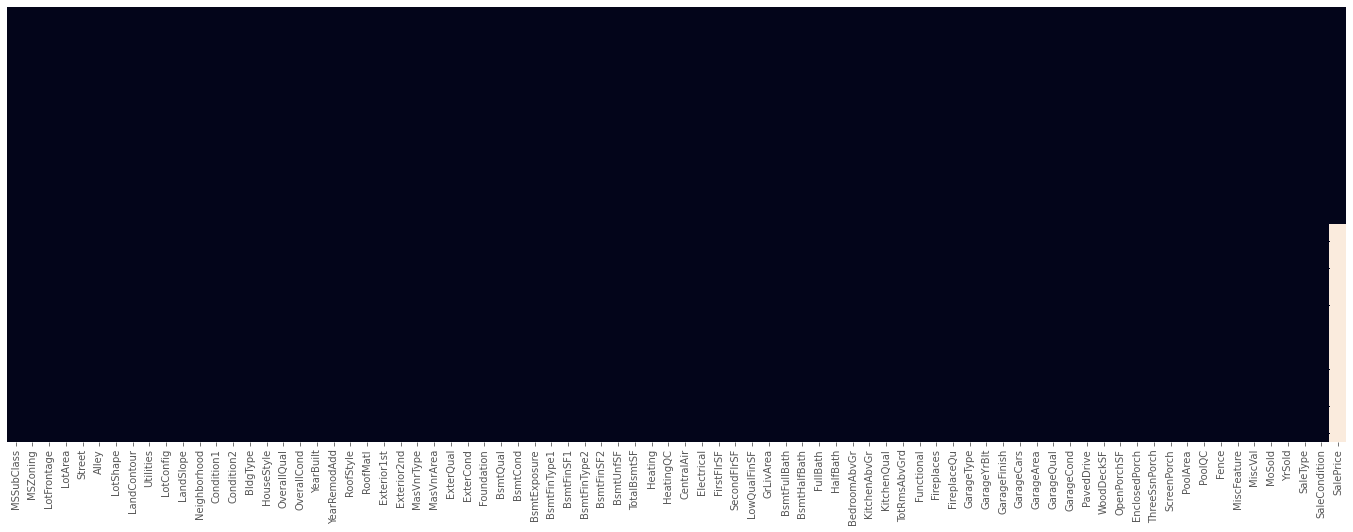

In [ ]:
plt.figure(figsize=(24,8))
sns.heatmap(data.isnull(),yticklabels=False,cbar=False)
plt.show()

## Correlation Matrix
The correlation matrix shows that ten features have a 0.50 or higher correlation with SalePrice.  These variables listed in order from highest correlation to lowest are: OverallQual, GrLivArea, GarageCars, GarageArea, TotalBsmtSF, FirstFlrSF, TotRmsAbvGrd, YearBuilt, and YearRemodAdd.  The overall material and finish of the house is by far the highest correlated feature with sales price at 0.79.

Features garage car capacity and garage square feet have the highest correlation at 0.89, which is not surprising.  Other notable features that are highly correlated are total rooms above ground and above grade living area square feet, year home built and year garage built, and first-floor square feet and basement square feet.  

Unexpectedly, the overall condition of the house does not have a high correlation with the sales price.  However, after further data exploration, it is determined that the ratings for overall condition are concentrated around five.  From the graph below, it is seen that overall quality has a more normal distribution than overall condition.  Therefore, it is understood why the home's overall condition has a low correlation with the sales price. 

In [ ]:
# Plot set up for correlation matrix
rc = {'font.size': 10, 'axes.labelsize': 16, 'legend.fontsize': 16, 'xtick.labelsize': 16, 'ytick.labelsize':16, }
plt.rcParams.update(rc)

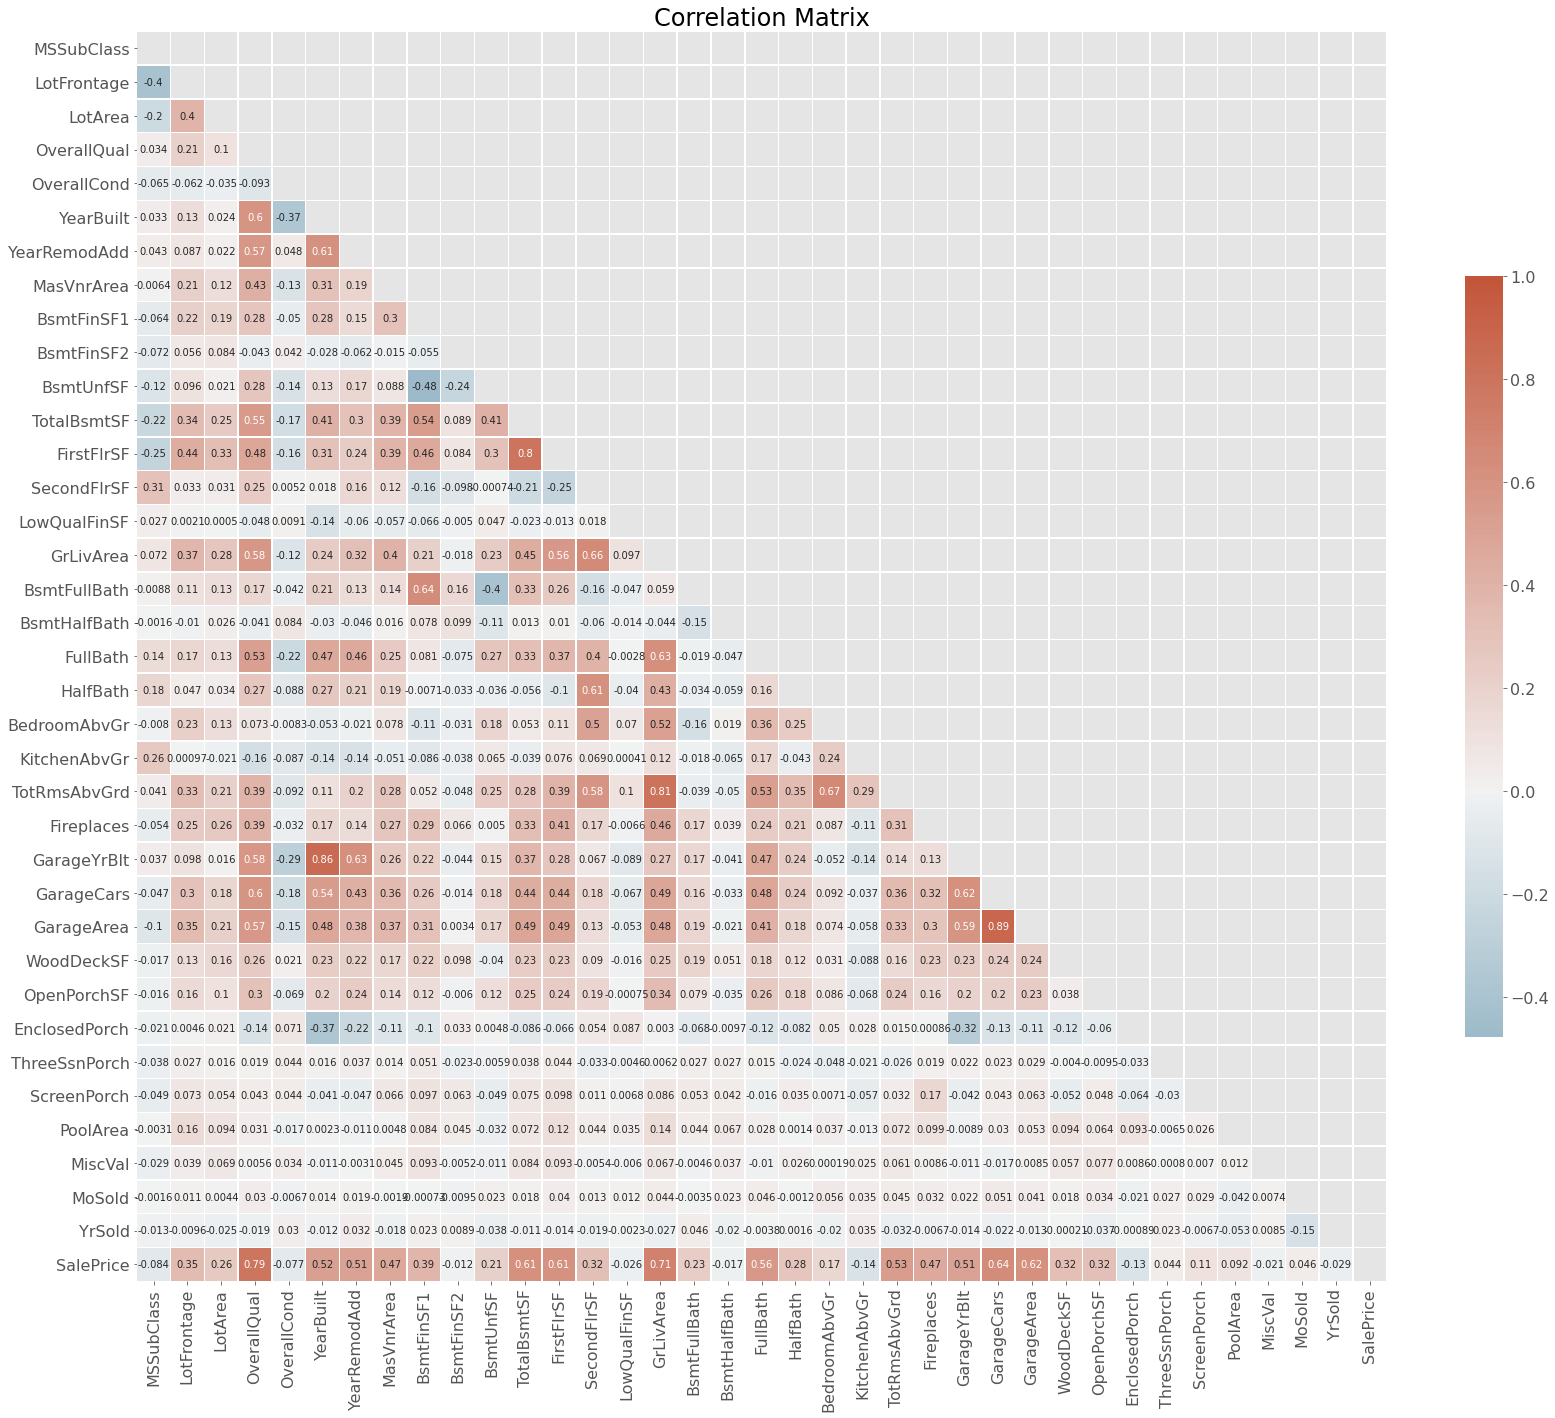

In [ ]:
# Correlation Matrix
f, ax = plt.subplots(figsize=(28, 28))
mat = data.corr('pearson')
mask = np.triu(np.ones_like(mat, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
corr = sns.heatmap(mat, mask=mask, cmap=cmap, vmax=1, center=0, annot = True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}).set_title('Correlation Matrix', fontsize=24)

plt.show()

### OverallQual and OverallCond Distributions

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


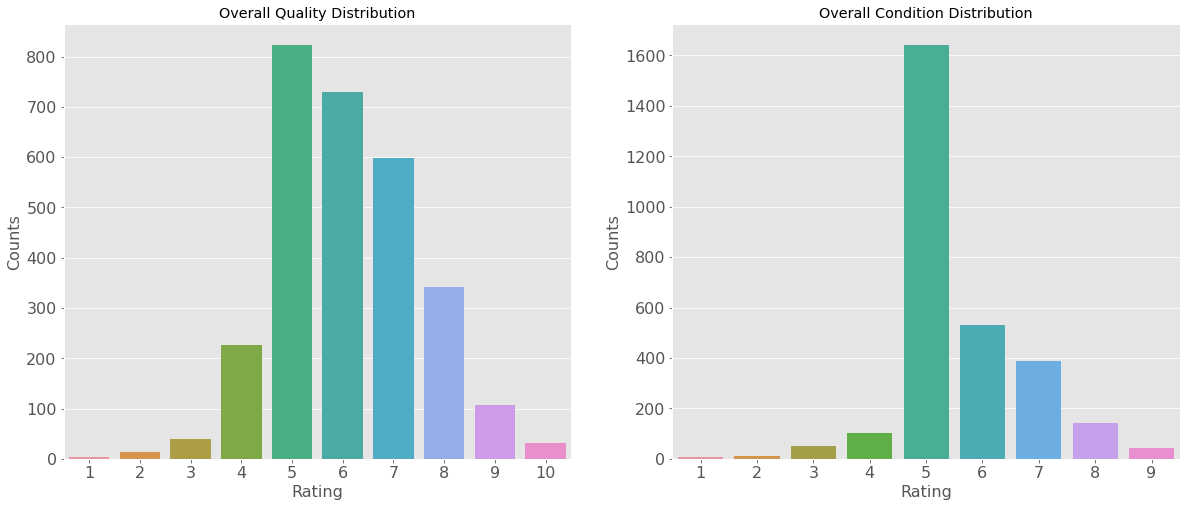

In [ ]:
# Plot set up
fig, axes = plt.subplots(1,2, figsize=(20,8))
style.use('ggplot')

# OverallQual Distirbution
overallqual_count = data['OverallQual'].value_counts() 
sns.barplot(overallqual_count.index, overallqual_count.values, ax=axes[0])
axes[0].set_title('Overall Quality Distribution')
axes[0].set_ylabel('Counts')
axes[0].set_xlabel('Rating')

# OverallCond Distribution
overallcond_count = data['OverallCond'].value_counts() 
sns.barplot(overallcond_count.index, overallcond_count.values, ax=axes[1])
axes[1].set_title('Overall Condition Distribution')
axes[1].set_ylabel('Counts')
axes[1].set_xlabel('Rating')

plt.show()

## Exploring OverallQual and GrLivArea

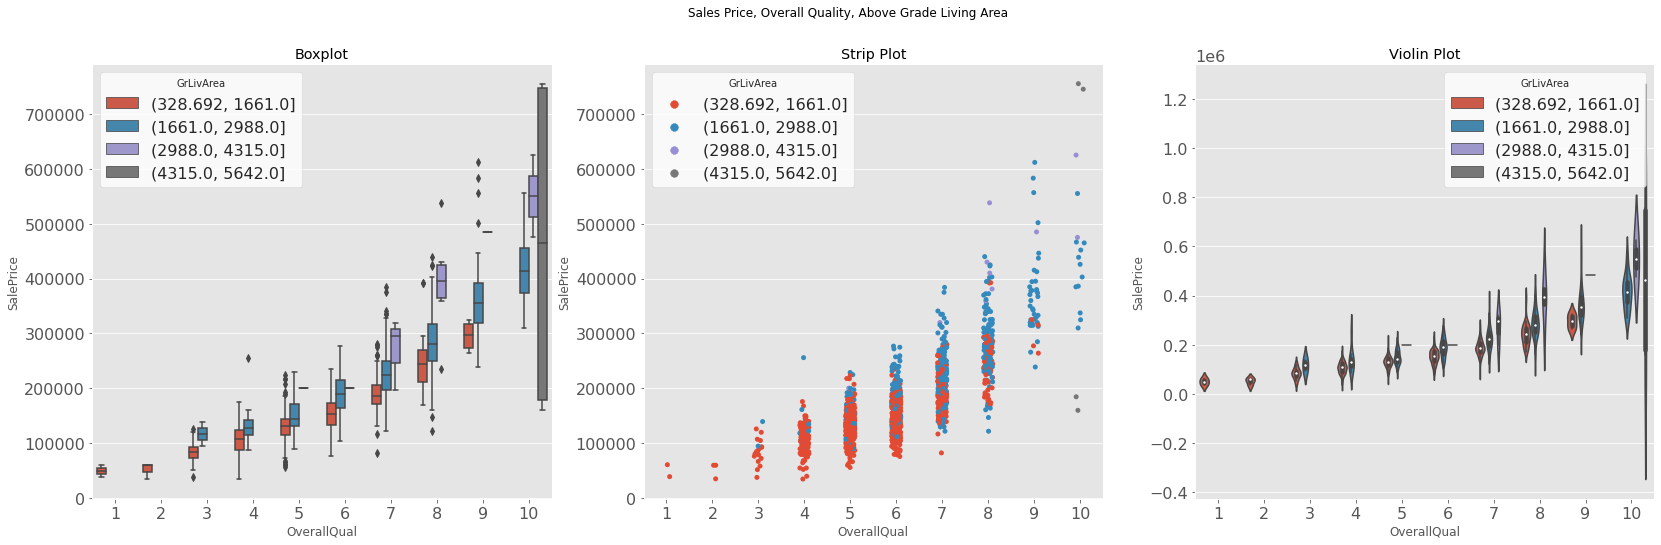

In [ ]:
# OverallQuall - SalePrice - GrLivArea
fig, axes = plt.subplots(1,3, figsize=(28,8))

fig.suptitle("Sales Price, Overall Quality, Above Grade Living Area")
sns.set_style("whitegrid")

# Box plot of OverallQual, SalePrice, and GrLivArea
sns.boxplot(data=train_data,x='OverallQual',y='SalePrice', hue=pd.cut(train_data["GrLivArea"], 4), ax=axes[0])
axes[0].set_title("Boxplot")

# Strip plot of OverallQual, SalePrice, and GrLivArea
sns.stripplot(data=train_data,x='OverallQual',y='SalePrice', hue=pd.cut(train_data["GrLivArea"], 4), ax=axes[1])
axes[1].set_title("Strip Plot")

# Violin plot of OverallQual, SalePrice, and GrLivArea
sns.violinplot(data=train_data,x='OverallQual',y='SalePrice', hue=pd.cut(train_data["GrLivArea"], 4), ax=axes[2])
axes[2].set_title("Violin Plot")


plt.show()

In [ ]:
# Reset rcParams to default 
plt.rcParams.update(plt.rcParamsDefault)

In [ ]:
# CONFIRM ALL NA VALUES ARE GONE (SALE PRICE SHOULD BE == 1459)
# data.isnull().sum(0).sort_values(ascending=False)

## Column Data Types

In [ ]:
  num_colums = ['LotFrontage', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 'GarageYrBlt', 
  'GarageCars', 'GarageArea', 'SalePrice', 'LotArea', 'YearBuilt', 'YearRemodAdd', 'FirstFlrSF', 'SecondFlrSF', 'LowQualFinSF', 'GrLivArea',
  'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', 
  'ThreeSsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal']

  cat_columns=['MSSubClass', 'OverallQual', 'OverallCond', 'MoSold', 'YrSold', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 
              'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 
              'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 
              'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 
              'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition']

  for col in cat_columns:
      data[col] = data[col].astype('object')

In [ ]:
# Turn all variables (columns) into dummy variables
def onehot_encoding(df, categorical_columns):

  valid_cat_columns = []
  # create new df
  new_df = df

  # remove columns that are not in cat_columns
  for col in categorical_columns:
    if col in df.columns: 
      valid_cat_columns.append(col)
  
  for i, col in enumerate(valid_cat_columns):

      # create dummies from column
      temp_df = pd.get_dummies(data[col], prefix=col, prefix_sep='_')
      
      # drop column from df
      df.drop([col],axis=1,inplace=True)

      # for first column, create new DF
      if i==0:
          new_df = temp_df.copy()

      # for subsequent columns, concat DFs
      else:
        new_df = pd.concat([new_df,temp_df],axis=1)

  # concat DF (with original columns not provided in columns list) with the dummy variables    
  new_df=pd.concat([df,new_df],axis=1)
      
  return new_df

# Split data (train, dev, test)

Use this line to get fresh data for each model, split into train, dev, test:


```
train_vectors, dev_vectors, train_SalePrice, dev_SalePrice, test_vectors = get_data(data, False)
```

Otherwise, just use

```
train_vectors, dev_vectors, train_SalePrice, dev_SalePrice, test_vectors = get_data(data, True)
```
to get train, test data to create a submission file.


In [ ]:
def get_data(data_frame, submission_flag=submission):
  all_data_frame = data_frame.copy()
  
  # Set the randomizer seed so results are the same each time.
  np.random.seed(0)

  # onehot_encode dataframe based off previously-created cat_columns 
  # this ensures that if a dataframe with features removed was passed into this function
  # only those columns still in the dataframe are encoded
  all_data_frame = onehot_encoding(all_data_frame, cat_columns)

  # Seperate data
  train_data = all_data_frame.loc[(all_data_frame['SalePrice'].notnull())]
  test_data = all_data_frame.loc[(all_data_frame['SalePrice'].isna())]

  # remove SalePrice from Train and dev data
  train_vectors = train_data.drop('SalePrice', axis = 1)

  # create label vector for train and dev data
  train_SalePrice = train_data['SalePrice']

  # remove SalePrice from Test data
  test_vectors = test_data.drop('SalePrice', axis = 1)

  # if submission_file is ON, create  ONLY train and test sets
  if submission_flag:
    return train_vectors, train_SalePrice, test_vectors

  # if submission_file is OFF, create train, dev, test sets
  else:
    # Create filter to split train and dev data (80% train, 20% dev)
    msk = np.random.rand(len(train_data)) < 0.8

    # remove SalePrice from Train and dev data
    train_vectors = train_data[msk].drop('SalePrice', axis = 1)
    dev_vectors = train_data[~msk].drop('SalePrice', axis = 1)

    # create label vector for train and dev data
    train_SalePrice = train_data[msk]['SalePrice']
    dev_SalePrice = train_data[~msk]['SalePrice']

    # create label vector for train and dev data
    train_SalePrice = train_data[msk]['SalePrice']

  return train_vectors, dev_vectors, train_SalePrice, dev_SalePrice, test_vectors

# Models

## Linear Model:

### Linear Model: All features

In [ ]:
submission = True

In [ ]:
if submission:
  train_vectors, train_SalePrice, test_vectors = get_data(data, True)

  reg = LinearRegression()
  reg.fit(train_vectors, np.log(train_SalePrice))
  y_pred = reg.predict(test_vectors)
  submission_file(np.exp(y_pred), 'linear_submission_log.csv')

train_vectors, dev_vectors, train_SalePrice, dev_SalePrice, test_vectors = get_data(data, False)
# Linear Regression, all
reg = LinearRegression()
reg.fit(train_vectors, np.log(train_SalePrice))

y_pred = reg.predict(dev_vectors)

print(f" Score {reg.score(dev_vectors, np.log(dev_SalePrice))}")
print(f" MSE {sklearn.metrics.mean_squared_error(np.exp(y_pred), dev_SalePrice)}")
print(f" RMSE {np.sqrt(sklearn.metrics.mean_squared_error(np.exp(y_pred), dev_SalePrice))}")

 Score 0.8634759862668789
 MSE 882966606.5409503
 RMSE 29714.754021208897


#### Linear Model with all Features
Rank: 5979    Score:  15623.551

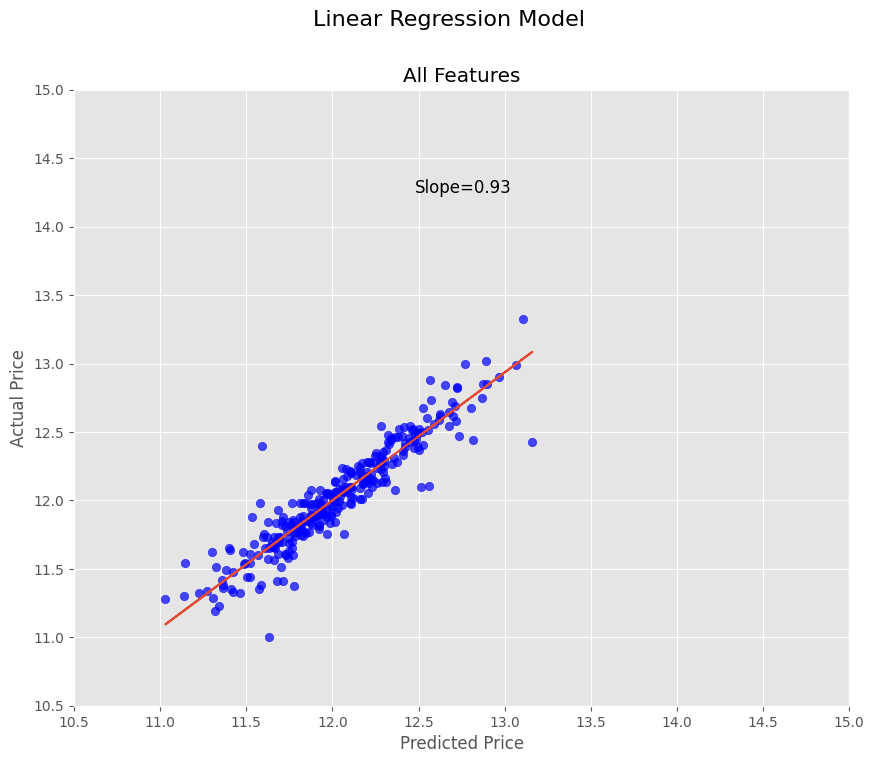

In [ ]:
# Plot set up
plt.style.use('ggplot')
plt.figure(figsize=(10,8))

# Set x and y variable
x, y = y_pred, np.log(dev_SalePrice)

# Scatter plot - fitted vs. actuals
plt.scatter(x, y, alpha=.7,
            color='b') #alpha helps to show overlapping data

# Line of best fit
m, b = np.polyfit(x, y, 1)
plt.plot(x, m*x + b)

# Plot set up
plt.xlabel('Predicted Price')
plt.ylabel('Actual Price')
plt.suptitle("Linear Regression Model", fontsize=16)
plt.title('All Features')
plt.xlim(10.5,15), plt.ylim(10.5,15)
plt.text(12.48,14.25,'Slope={}'.format(round(m,2)), fontsize=12)
plt.show()

#### Outlier Discussion
Several apparent outliers were apparent in the first run.  With this information, we elected to drop IDs [1298, 523, 1100, 533] from the training data.

Lets attempt to handle with some python libraries

[Cited Work](https://machinelearningmastery.com/model-based-outlier-detection-and-removal-in-python/)



In [ ]:
train_vectors, dev_vectors, train_SalePrice, dev_SalePrice, test_vectors = get_data(data, False)

In [ ]:
mae = 1

# summarize the shape of the updated training dataset
print('Original Shapes: ', train_vectors.shape, train_SalePrice.shape)

while mae > .097:
  # Show Mean Abs Error for original model
  mae = sklearn.metrics.mean_absolute_error(np.log(dev_SalePrice), y_pred)
  
  X_train, y_train = train_vectors, train_SalePrice
  X_test, y_test = dev_vectors, dev_SalePrice

  # identify outliers in the training dataset
  iso = IsolationForest(contamination=.09)
  yhat = iso.fit_predict(X_train)
  mask = yhat != -1

  X_train, y_train = X_train[mask], y_train[mask]

  # fit the model
  model = LinearRegression()
  model.fit(X_train, np.log(y_train))

  # evaluate the model
  yhat = model.predict(X_test)

  # evaluate predictions
  mae = sklearn.metrics.mean_absolute_error(np.log(y_test), yhat)

  print('Processed MAE: %.3f' % mae)

# summarize the shape of the updated training dataset
print(X_train.shape, y_train.shape)

# evaluate the model
print(f" Score {model.score(X_test, np.log(y_test))}")
print(f" MSE {sklearn.metrics.mean_squared_error(yhat, np.log(dev_SalePrice))}")
print(f" RMSE {np.sqrt(sklearn.metrics.mean_squared_error(np.exp(yhat), dev_SalePrice))}")

if submission:

  # evaluate the model
  y_pred = model.predict(test_vectors)
  submission_file(np.exp(y_pred), 'isolation_forest_log.csv')

Original Shapes:  (1153, 349) (1153,)
Processed MAE: 0.084
(1049, 349) (1049,)
 Score 0.9063841454677101
 MSE 0.014286530279009247
 RMSE 23490.88722818721


#### Linear Model with all Features and outliers removed
Rank: 2002    Score:  14223.31 ***Most optimal model***

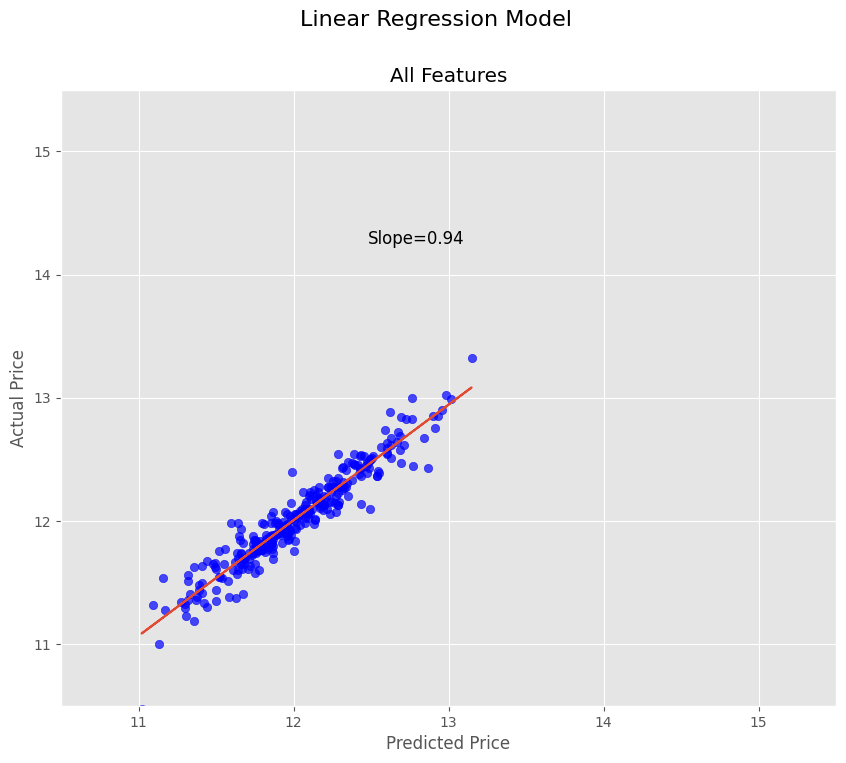

In [ ]:
# Plot set up
plt.style.use('ggplot')
plt.figure(figsize=(10,8))

# Set x and y variable
x, y = yhat, np.log(y_test)

# Scatter plot - fitted vs. actuals
plt.scatter(x, y, alpha=.7,
            color='b') #alpha helps to show overlapping data

# Line of best fit
m, b = np.polyfit(x, y, 1)
plt.plot(x, m*x + b)

# Plot set up
plt.xlabel('Predicted Price')
plt.ylabel('Actual Price')
plt.suptitle("Linear Regression Model", fontsize=16)
plt.title('All Features')
plt.xlim(10.5,15.5), plt.ylim(10.5,15.5)
plt.text(12.48,14.25,'Slope={}'.format(round(m,2)), fontsize=12)
plt.show()

### Linear Model: Selective Features

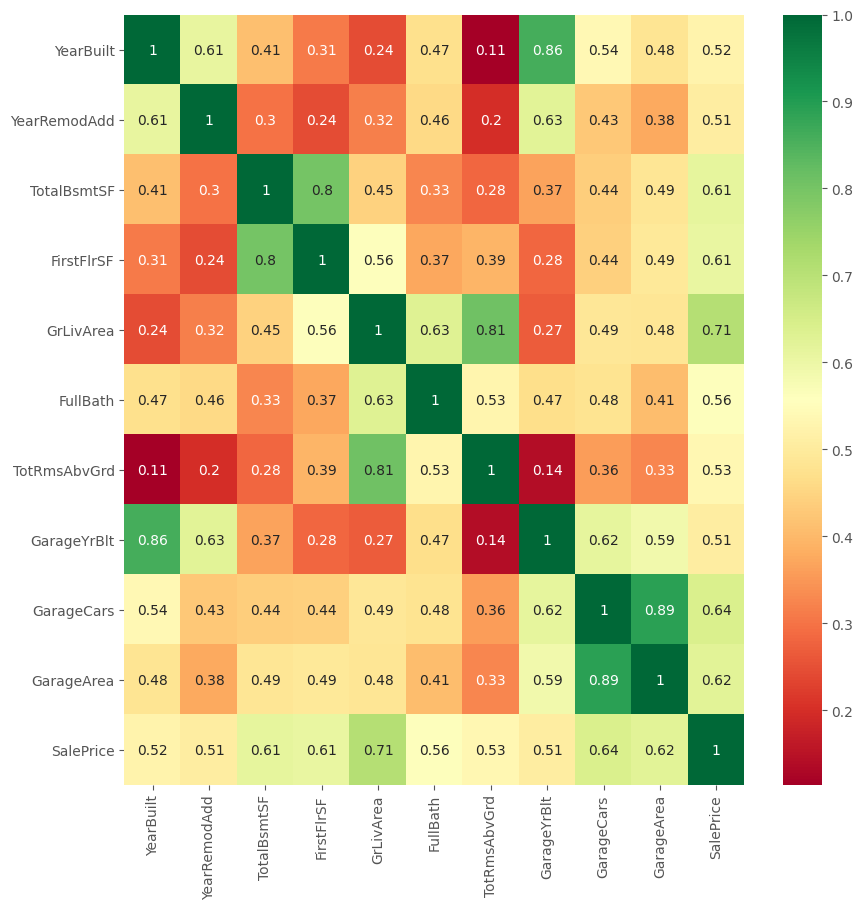

In [ ]:
# Correlation Matrix
corr = data.corr()
highest_corr_features = corr.index[abs(corr["SalePrice"])>0.5] 
plt.figure(figsize=(10,10))
g = sns.heatmap(data[highest_corr_features].corr(),annot=True,cmap="RdYlGn")

In [ ]:
df = data[highest_corr_features]
df["OverallQual"] = data["OverallQual"]

train_vectors, dev_vectors, train_SalePrice, dev_SalePrice, test_vectors = get_data(df, False)

# Linear Regression, all
reg = LinearRegression()
reg.fit(train_vectors, np.log(train_SalePrice))

y_pred = reg.predict(dev_vectors)
print(reg.score(dev_vectors, np.log(dev_SalePrice)))
print(sklearn.metrics.mean_squared_error(y_pred, np.log(dev_SalePrice)))
print(np.sqrt(sklearn.metrics.mean_squared_error(y_pred, np.log(dev_SalePrice))))

X_train, y_train, X_test, y_test = train_vectors, train_SalePrice, dev_vectors, dev_SalePrice

# Show Mean Abs Error for original model
mae = sklearn.metrics.mean_absolute_error(np.log(y_test), y_pred)
print('Original MAE: %.3f' % mae)

# summarize the shape of the updated training dataset
print('Original Shapes: ', train_vectors.shape, train_SalePrice.shape)

# identify outliers in the training dataset
iso = IsolationForest(contamination=0.1)
yhat = iso.fit_predict(X_train)
mask = yhat != -1

X_train, y_train = X_train[mask], y_train[mask]

# summarize the shape of the updated training dataset
print(X_train.shape, y_train.shape)

# fit the model
model = LinearRegression()
model.fit(X_train, np.log(y_train))

# evaluate the model
yhat = model.predict(X_test)

# evaluate predictions
mae = sklearn.metrics.mean_absolute_error(np.log(y_test), yhat)
print('MAE: %.3f' % mae)

# evaluate the model
yhat = model.predict(test_vectors)
submission_file(np.exp(yhat), 'linear_regression_selective.csv')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


0.8666217142293313
0.02035459621391116
0.14266953498876753
Original MAE: 0.106
Original Shapes:  (1153, 20) (1153,)
(1037, 20) (1037,)
MAE: 0.104


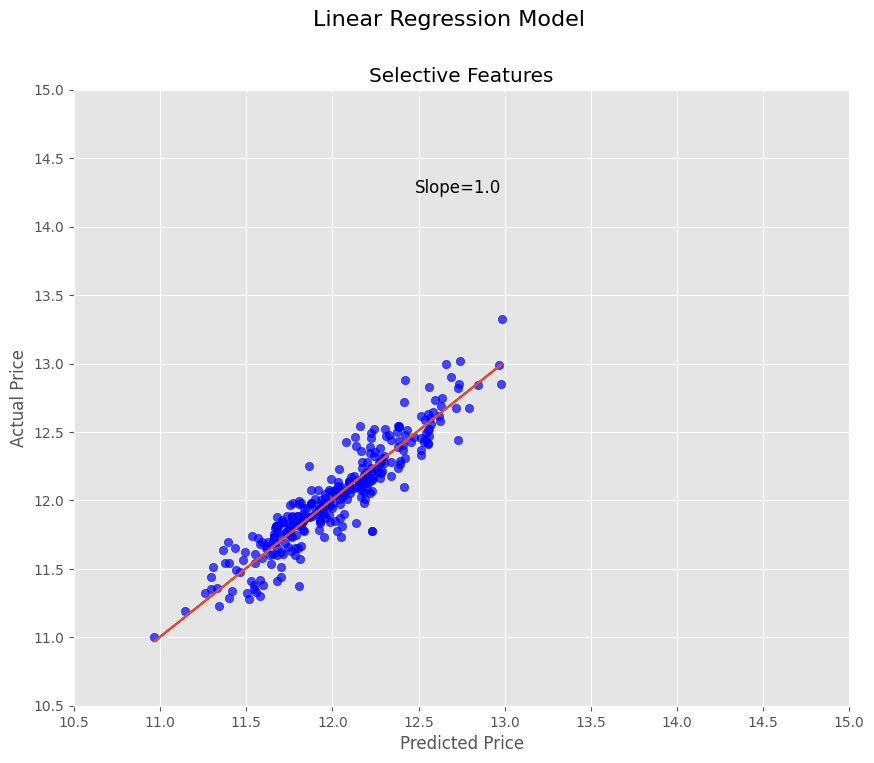

In [ ]:
# Plot set up
plt.style.use('ggplot')
plt.figure(figsize=(10,8))

# Scatter plot - fitted vs. actual
plt.scatter(y_pred, np.log(dev_SalePrice), alpha=.7,
            color='b') #alpha helps to show overlapping data

# Line of best fit
x, y = y_pred, np.log(dev_SalePrice).to_numpy()
m, b = np.polyfit(x, y, 1)
plt.plot(x, m*x + b)

# Plot set up
plt.xlabel('Predicted Price')
plt.ylabel('Actual Price')
plt.suptitle("Linear Regression Model", fontsize=16)
plt.title('Selective Features')
plt.xlim(10.5,15), plt.ylim(10.5,15)
plt.text(12.48,14.25,'Slope={}'.format(round(m,2)), fontsize=12)
plt.show()

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


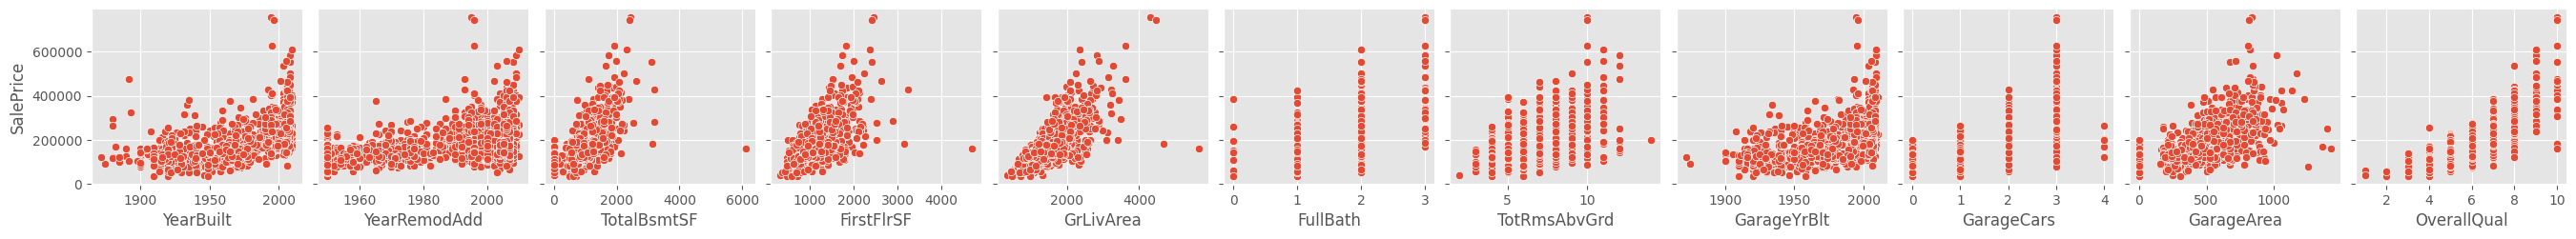

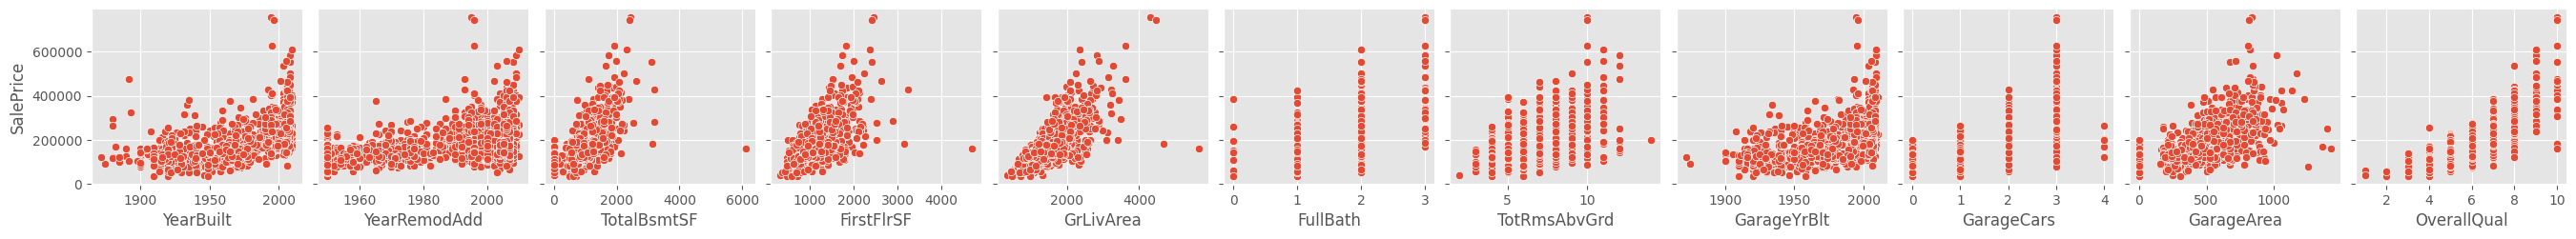

In [ ]:
sns.pairplot(data=data,
                  y_vars=['SalePrice'],
                  x_vars=df.drop(['SalePrice'],axis=1,inplace=False).columns)

new_df = df

new_df.TotalBsmtSF = np.log(new_df.TotalBsmtSF)

sns.pairplot(data=data,
                  y_vars=['SalePrice'],
                  x_vars=df.drop(['SalePrice'],axis=1,inplace=False).columns)
plt.show()

## Lasso:


In [ ]:
train_vectors, dev_vectors, train_SalePrice, dev_SalePrice, test_vectors = get_data(data, False)

# generate a range of alpha
alpha=np.arange(0.01, 1, 0.0005)
score_best = 0
i_best = 0
# initiate a lasso model using different alpha
for i in alpha:
  las = Lasso(alpha=i)
  las_fit = las.fit(train_vectors, np.log(train_SalePrice))
  score = las.score(dev_vectors, np.log(dev_SalePrice))
  # pick up the best score and its coresponding alpha
  if score > score_best:
    score_best = score
    alpha_best = i
# print out the best alpha and its score
# print(alpha_best,score_best)
print('score:',score_best)

# predict on dev data
las_best = Lasso(alpha=alpha_best)
las_best_fit = las_best.fit(train_vectors, np.log(train_SalePrice))
las_pred = las_best.predict(dev_vectors)
# print out the MSE and RMSE
print('MSE:',sklearn.metrics.mean_squared_error(las_pred, np.log(dev_SalePrice)))
print('RMSE:',np.sqrt(sklearn.metrics.mean_squared_error(las_pred, np.log(dev_SalePrice))))

if submission:

  train_vectors, train_SalePrice, test_vectors = get_data(data, True)

  las_best_fit = las_best.fit(train_vectors, np.log(train_SalePrice))
  y_pred = las_best.predict(test_vectors)
  submission_file(np.exp(y_pred), 'lasso_log.csv')

score: 0.8602606719733409
MSE: 0.021325342283049668
RMSE: 0.14603199061524041


In [ ]:
# print out the number of features selected by the model
selected_feat = train_vectors.columns[(SelectFromModel(las_best,prefit=True).get_support())]
print('total features: {}'.format((train_vectors.shape[1])))
print('selected features: {}'.format(len(selected_feat)))

## Enet:


In [ ]:
train_vectors, dev_vectors, train_SalePrice, dev_SalePrice, test_vectors = get_data(data, False)

# generate a range of alpha
alpha=np.arange(0.01, 1, 0.0005)
score_best = 0
i_best = 0
# initiate a ENet model using different alpha
for i in alpha:
  enet = ElasticNet(alpha=i)
  enet_fit = enet.fit(train_vectors, np.log(train_SalePrice))
  score = enet.score(dev_vectors, np.log(dev_SalePrice))
  # pick up the best score and its coresponding alpha
  if score > score_best:
    score_best = score
    alpha_best = i
# print out the best alpha and its score
# print(alpha_best,score_best)
print('score:',score_best)

# predict on dev data
enet_best = ElasticNet(alpha=alpha_best)
enet_best_fit = enet_best.fit(train_vectors, np.log(train_SalePrice))
enet_pred = enet_best.predict(dev_vectors)
# print out the MSE and RMSE
print('MSE:',sklearn.metrics.mean_squared_error(enet_pred, np.log(dev_SalePrice)))
print('RMSE:',np.sqrt(sklearn.metrics.mean_squared_error(enet_pred, np.log(dev_SalePrice))))

if submission:

  train_vectors, train_SalePrice, test_vectors = get_data(data, True)

  net_best_fit = enet_best.fit(train_vectors, np.log(train_SalePrice))
  y_pred = enet_best.predict(test_vectors)
  submission_file(np.exp(y_pred), 'enet_log.csv')

## XGBoost:

In [ ]:
regressor=xgboost.XGBRegressor()

booster=['gbtree','gblinear']
base_score=[0.25,0.5,0.75,1]

## Hyper Parameter Optimization
n_estimators = [100, 500, 900, 1100, 1500]
max_depth = [2, 3, 5, 10, 15]
booster=['gbtree','gblinear']
learning_rate=[0.05,0.1,0.15,0.20]
min_child_weight=[1,2,3,4]

# Define the grid of hyperparameters to search
hyperparameter_grid = {
    'n_estimators': n_estimators,
    'max_depth':max_depth,
    'learning_rate':learning_rate,
    'min_child_weight':min_child_weight,
    'booster':booster,
    'base_score':base_score
    }

# Set up the random search with 4-fold cross validation
random_cv = GridSearchCV(estimator=regressor,
            param_grid=hyperparameter_grid,
            cv=5, 
            scoring = 'neg_mean_absolute_error',n_jobs = 4,
            verbose = 5, 
            return_train_score = True
            )

if submission:
  # comment out when not fitting model ***TAKES A WHILE***
  random_cv.fit(train_vectors, train_SalePrice)
  filename = 'xgboost_model.pkl'
  pickle.dump(regressor, open(filename, 'wb'))



# Conclusion

Considerable EDA was required in this project, with a fair amount of feature engineering as well.  Although there is certainly room to address distribution and skewness of additional features, we are quite satisfied with our linear model regression techniques.  Although we only ranked ~ 2000, because of the way Kaggle scores only half the test set prior to the close of the competition, we feel confident a good portion of the higher-ranked models will suffer from overfitting.

Overall, we included six models in our project：LinearRegression, LR with outlier removed, LR with features with correlation above 0.5, Lasso and Enet, as well as XGBoost. 

Additional model comparison with pros and cons can be found in the associated slide deck.
